# Quick mcfly tutorial: RacketSports dataset

The goal of this tutorial is to get you familiar with training Neural Networks for time series using mcfly. At the end of the tutorial, you will have compared several Neural Network architectures you know how to train the best performing network.

Here we use a rather simple time seris dataset as an example, the publicly available [RacketSports dataset](http://www.timeseriesclassification.com/description.php?Dataset=RacketSports). It contains time series data from movement sensors from mobile phones when playing either Squash or Badminton. The data is labelled with the activity types that these individuals did and the aim is to train and evaluate a *classifier*.

Before you can start, please make sure you install mcfly (see the [mcfly installation page](https://github.com/NLeSC/mcfly)).

## Import required Python modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd

# mcfly
import mcfly
import tensorflow as tf
np.random.seed(2)

In [2]:
sys.path.insert(0, os.path.abspath('../..'))
from utils import tutorial_racketsports

## Download data pre-procesed data

We have created a function for you to fetch the preprocessed data from https://zenodo.org/record/3743603. Please specify the `directory_to_extract_to` in the code below and then execute the cell. This will download the preprocessed data into the directory in the `RacketSports` subdirectory. The output of the function is the path where the preprocessed data was stored.

In [5]:
# Specify in which directory you want to store the data:
directory_to_extract_to = '.'

In [6]:
data_path = tutorial_racketsports.download_preprocessed_data(directory_to_extract_to)

Extracting data...
Done


## A bit about the data

The [RacketSports dataset](http://www.timeseriesclassification.com/description.php?Dataset=RacketSports) contains motion sensor data of a smart watch from people playing Squash or Badminton. It contains the sensor data from gyroscope (= 3 channels) and accelerometer (= 3 channels), hence has a total of 6 channels. 

The problem is to identify which sport and which stroke the players are making. The data was collected at a rate of 10 HZ over 3 seconds whilst the player played either a forehand/backhand in squash or a clear/smash in badminton.

The goal of classification is to assign an activity label to an previously unseen segment.

## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files. Please note that the data has already been split up in a training (\~50%), validation (\~25%), and test (\~25%) subsets. It is common practice to call the input data X and the labels y.

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = tutorial_racketsports.load_data(data_path)

Data X and labels y are of type Numpy array. In the cell below we inspect the shape of the data. As you can see the shape of X is expressed as a Python tuple containing: the number of samples, length of the time series, and the number of channels for each sample. Similarly, the shape of y is represents the number of samples and the number of classes (unique labels). 

In [10]:
print('X training shape:', X_train.shape)
print('y training shape:', y_train.shape)
print('y validation shape:', y_val.shape)
print('y test shape:', y_test.shape)

X training shape: (151, 30, 6)
y training shape: (151,)
y validation shape: (75,)
y test shape: (77,)


### Inspect labels (and prepare for model training)
The labels are given as strings as provided in the original data. Those indicate one of the four possible classes:

In [17]:
labels_unique = np.unique(y_train)
print(labels_unique)

['Badminton_Clear' 'Badminton_Smash' 'Squash_BackhandBoast'
 'Squash_ForehandBoast']


### Create binary labels
To train a classifier the labels need to be translated into binary labels (so called **one-hot encoding**).

In [19]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labels_unique)

LabelBinarizer()

In [25]:
y_train_binary = lb.fit_transform(y_train)
y_val_binary = lb.fit_transform(y_val)
y_test_binary = lb.fit_transform(y_test)

In [21]:
y_train_binary[:10,:]

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0]])

If we want to see the class labels again, we can use:

In [24]:
print(lb.classes_)

['Badminton_Clear' 'Badminton_Smash' 'Squash_BackhandBoast'
 'Squash_ForehandBoast']


### Visualize the data 
(optional, but usually nice to get an idea of how it looks like and if everything is as expected)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


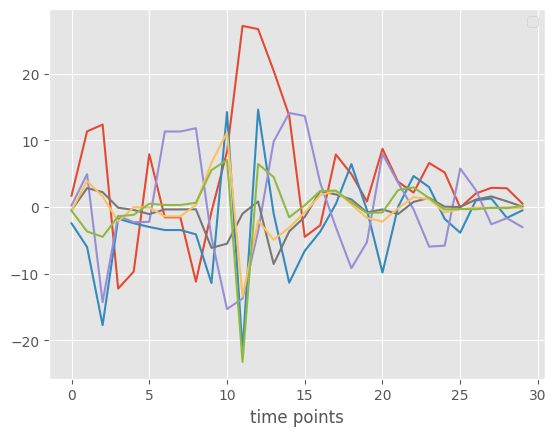

In [29]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.plot(np.array(X_train[10,:,:]))
plt.xlabel('time points')
plt.legend()

### *Question 1: How many channels does this dataset have?*
### *Question 2: What is the least common activity label in this dataset?*

    

## Generate models

First step in the development of any deep learning model is to create a model architecture. As we do not know what architecture is best for our data we will create a set of random models to investigate which architecture is most suitable for our data and classification task. This process, creating random models, checking how good they are and then selecting the best one is called a 'random search'. A random search is considered to be the most robust approach to finding a good model. You will need to specificy how many models you want to create with argument 'number_of_models'. See for a full overview of the optional arguments the function documentation of modelgen.generate_models by running `modelgen.generate_models?`.

##### What number of models to select?
This number differs per dataset. More models will give better results but it will take longer to evaluate them. Because mcfly uses random search, you will get better results when using more models. Here we will generate 8 models to keep the training short for this tutorial, but it could just as well be done for 12, or 20 models.

In [31]:
num_classes = y_train_binary.shape[1]
metric = 'accuracy'
models = mcfly.modelgen.generate_models(X_train.shape,
                                        number_of_classes=num_classes,
                                        number_of_models = 8,
                                        metrics=[metric])

The value of metrics is set from ['accuracy'] (default) to ['accuracy']
Set maximum kernel size for InceptionTime models to number of timesteps.


# Inspect the models
We can have a look at the models that were generated. The layers are shown as table rows. Most common layer types are 'Convolution' and 'LSTM' and 'Dense'. For more information see the [mcfly user manual](https://github.com/NLeSC/mcfly/wiki/User-manual) and the [tutorial cheat sheet](https://github.com/NLeSC/mcfly-tutorial/blob/master/cheatsheet.md). The summary also shows the data shape of each layer output and the number of parameters that are trained within this layer.

In [36]:
models_to_print = range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i), '\n')          
        print("Model type:", model_types, '\n')        
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()        
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0 

Model type: ResNet 

Hyperparameters:
{'learning_rate': 0.005481464347736465, 'regularization_rate': 0.010209289921137055, 'network_depth': 5, 'min_filters_number': 107, 'max_kernel_size': 29}
 
Model description:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 6)]      0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 6)       24          ['input_1[0][0]']                
 alization)                                                                                       
                                                               

                                                                                                  
 conv1d_11 (Conv1D)             (None, 30, 212)      45156       ['re_lu_8[0][0]']                
                                                                                                  
 add_2 (Add)                    (None, 30, 212)      0           ['re_lu_8[0][0]',                
                                                                  'conv1d_11[0][0]']              
                                                                                                  
 conv1d_12 (Conv1D)             (None, 30, 299)      634179      ['add_2[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 30, 299)     1196        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv1d_22 (Conv1D)             (None, 30, 69)       17664       ['conv1d_20[0][0]']              
                                                                                                  
 conv1d_23 (Conv1D)             (None, 30, 69)       8832        ['conv1d_20[0][0]']              
                                                                                                  
 conv1d_24 (Conv1D)             (None, 30, 69)       414         ['max_pooling1d[0][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 30, 276)      0           ['conv1d_21[0][0]',              
                                                                  'conv1d_22[0][0]',              
                                                                  'conv1d_23[0][0]',              
          

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_21 (Bat  (None, 30, 6)            24        
 chNormalization)                                                
                                                                 
 reshape (Reshape)           (None, 30, 6, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 30, 6, 48)         192       
                                                                 
 batch_normalization_22 (Bat  (None, 30, 6, 48)        192       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 30, 6, 48)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 6, 43)         6235      
          

 activation_17 (Activation)  (None, 30, 73)            0         
                                                                 
 conv1d_45 (Conv1D)          (None, 30, 89)            19580     
                                                                 
 batch_normalization_36 (Bat  (None, 30, 89)           356       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 30, 89)            0         
                                                                 
 flatten (Flatten)           (None, 2670)              0         
                                                                 
 dense_3 (Dense)             (None, 1595)              4260245   
                                                                 
 activation_19 (Activation)  (None, 1595)              0         
                                                                 
 dense_4 (

 ormalization)                                                                                    
                                                                                                  
 re_lu_21 (ReLU)                (None, 30, 93)       0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv1d_55 (Conv1D)             (None, 30, 93)       69285       ['re_lu_21[0][0]']               
                                                                                                  
 batch_normalization_46 (BatchN  (None, 30, 93)      372         ['conv1d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_22 (ReLU)                (None, 30, 93)       0           ['batch_normalization_46[0][0]'] 
          

                                                                  'conv1d_65[0][0]',              
                                                                  'conv1d_66[0][0]']              
                                                                                                  
 batch_normalization_52 (BatchN  (None, 30, 356)     1424        ['concatenate_3[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 30, 356)      0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 conv1d_67 (Conv1D)             (None, 30, 32)       11392       ['activation_21[0][0]']          
                                                                                                  
 max_pooli

                                                                                                  
 conv1d_83 (Conv1D)             (None, 30, 32)       11392       ['activation_25[0][0]']          
                                                                                                  
 max_pooling1d_7 (MaxPooling1D)  (None, 30, 356)     0           ['activation_25[0][0]']          
                                                                                                  
 conv1d_84 (Conv1D)             (None, 30, 89)       54112       ['conv1d_83[0][0]']              
                                                                                                  
 conv1d_85 (Conv1D)             (None, 30, 89)       25632       ['conv1d_83[0][0]']              
                                                                                                  
 conv1d_86 (Conv1D)             (None, 30, 89)       11392       ['conv1d_83[0][0]']              
          

                                                                 
 batch_normalization_66 (Bat  (None, 30, 6, 96)        384       
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 30, 6, 96)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 6, 80)         23120     
                                                                 
 batch_normalization_67 (Bat  (None, 30, 6, 80)        320       
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 30, 6, 80)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 6, 29)         6989      
                                                                 
 batch_nor

For a very quick view we can also just look the list of created models itself:

In [37]:
models

[(<keras.engine.functional.Functional at 0x27264fc50c0>,
  {'learning_rate': 0.005481464347736465,
   'regularization_rate': 0.010209289921137055,
   'network_depth': 5,
   'min_filters_number': 107,
   'max_kernel_size': 29},
  'ResNet'),
 (<keras.engine.functional.Functional at 0x27265e7b5b0>,
  {'learning_rate': 0.0436664988829779,
   'regularization_rate': 0.003503259200059715,
   'network_depth': 3,
   'filters_number': 69,
   'max_kernel_size': 17},
  'InceptionTime'),
 (<keras.engine.sequential.Sequential at 0x2726529d4b0>,
  {'learning_rate': 0.0394693672382836,
   'regularization_rate': 0.002879158913712458,
   'filters': [48, 43, 68, 77],
   'lstm_dims': [78]},
  'DeepConvLSTM'),
 (<keras.engine.sequential.Sequential at 0x27265e79fc0>,
  {'learning_rate': 0.012851236876927944,
   'regularization_rate': 0.013689688066052806,
   'filters': array([ 41,  76,  90,  62,  86,  60,  14, 100,  73,  89]),
   'fc_hidden_nodes': 1595},
  'CNN'),
 (<keras.engine.functional.Functional at 0

### *Question 3: Can you guess what hyperparameter 'learning rate' stands for?*

## Compare models
Now that the model architectures have been generated it is time to compare the models by training them on a subset of the training data and evaluating the models on the validation subset. This will help us to choose the best candidate model. The performance results for the models are stored in a json file, which we will visually inspect later on.

In [38]:
# Define directory where the results, e.g. json file, will be stored
resultpath = os.path.join(directory_to_extract_to, 'models')
if not os.path.exists(resultpath):
    os.makedirs(resultpath)

### Train models
We are now going to train each of the models that we generated. On the one hand we want to train them as quickly as possible in order to be able to pick the best one as soon as possible. On the other hand we have to train each model long enough to get a good impression of its potential. As default mcfly uses **early stopping** which means that it will stop the training once the models accuracy on the validation set decreases. To better account for usually occuring fluctuations in the accuracy, we here set **early_stopping_patience = 5** which means that the model will stop if the validation accuracy has not improved since 5 epochs.

We can influence the train time by adjusting the number of data samples that are used. This can be set with the argument 'subset_size'. We can also adjust the number of times the subset is iterated over. This number is called an epoch. For more complex dataset we recommend to start with no more than 5 epochs and a maximum subset size of 300. You can experiment with these numbers.

Here, however, we work with a very small dataset (in terms of time resolution, channels, and number of samples). So we can run at longer training already.

### The following training will take several minutes to run.
This depends on the model architectures that were generated, the data used, and -obviously- the hardware this code is run on.

In [42]:
from mcfly.find_architecture import train_models_on_samples

outputfile = os.path.join(resultpath, 'modelcomparison.json')
histories, val_accuracies, val_losses = train_models_on_samples(X_train, y_train_binary,
                                                                X_val, y_val_binary,
                                                                models, nr_epochs=20,
                                                                subset_size=300,
                                                                early_stopping_patience = 5,
                                                                verbose=True,
                                                                outputfile=outputfile,
                                                                metric=[metric])
print('Details of the training process were stored in ',outputfile)

Generated models will be trained on subset of the data (subset size: 300).
Training model 0 ResNet


ValueError: Invalid metric: "['accuracy']" is not among the metrics the models was compiled with ([]).

In [46]:
models[0][0].metrics_names

[]

In [45]:
models[0][0].compile?

### *Question 4: What do the terms 'acc' and 'loss' in the output refer to?*

# Inspect model performance (Visualization)

We can inspect the learning process in the visualization tool on http://nlesc.github.io/mcfly/.

Alternatively, you can run the visualization from a local web service:
- Clone the mcfly github repository (if you haven't done so already for visualization)

 `git clone https://github.com/NLeSC/mcfly`


- navigate to the html folder:

 `cd mcfly/html`


- Start a web server. This can be done in various ways, for example:
`python3 -m http.server`

Notice the port number the web server is serving on. This is usually 8000.
With a web browser, navigate to [localhost:8000](localhost:8000). 

You need to upload the json file that contains the details of the training process. The following line of code shows the path to this file:

In [21]:
outputfile

'.\\data\\models\\modelcomparison.json'

### *Question 5:  Look at the visualization. Which model performs best?*
### *Question 6:  Did you train all models with a sufficient number of iterations?*
### *Question 7:  Are there cases of clear overfitting?*

# Inspect model performance (table)

Let's compare the performance of the models by showing the results as a table.

In [22]:
metric = 'accuracy'
modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                                'model-type':[str(model_types) for model, params, model_types in models],
                                'train_{}'.format(metric): [history.history[metric][-1] for history in histories],
                                'train_loss': [history.history['loss'][-1] for history in histories],
                                'val_{}'.format(metric): [history.history['val_{}'.format(metric)][-1] for history in histories],
                                'val_loss': [history.history['val_loss'][-1] for history in histories]
                                })
modelcomparisons.to_csv(os.path.join(resultpath, 'modelcomparisons.csv'))

modelcomparisons

,model,model-type,train_accuracy,train_loss,val_accuracy,val_loss
0,"{'learning_rate': 0.005481464347736465, 'regul...",ResNet,0.450331,1.090753,0.253333,10.486857
1,"{'learning_rate': 0.0436664988829779, 'regular...",InceptionTime,0.980132,0.069513,0.360000,30.067336
2,"{'learning_rate': 0.0394693672382836, 'regular...",DeepConvLSTM,0.205298,1.621776,0.226667,1.492279
3,"{'learning_rate': 0.012851236876927944, 'regul...",CNN,0.841060,1.361104,0.226667,3.304446
4,"{'learning_rate': 0.008923210639822017, 'regul...",ResNet,0.913907,0.207766,0.653333,224.207554
5,"{'learning_rate': 0.00041757142225341446, 'reg...",InceptionTime,1.000000,0.005901,0.906667,0.347267
6,"{'learning_rate': 0.0007902107985188801, 'regu...",CNN,0.993378,0.478264,0.760000,1.037439
7,"{'learning_rate': 0.005216294589208116, 'regul...",DeepConvLSTM,0.827815,0.758923,0.640000,1.303036


# Next steps:
## 1) Continue iteratively: generate more models of desired type
*mcfly* is generating models of 4 different architecture types (CNN, DeepConvLSTM, ResNet, InceptionTime). There performance of course strongly depends on the hyperparameters used, but they also all have different strengths and weaknesses. Often it makes sense to select the most promising type(s) after the first screening we did above and continue to explore options further.

### Narrow the search: model types
In this case, let's say that the most promising models were of typ CNN and InceptionTime. So we will ignore the other architecture for now.
We can do this in *mcfly* by specifing which models we want to generate: ``model_types = ['CNN', 'InceptionTime']``

### Narrow the search: hyperparameters
Figuring out which hyperparameters work better than others can be very complicated since often there exist complex links between them. But let's say we already figured something out, e.g. that high learning rates lead to overfitting on our data. Then *mcfly* easily allows to restrict the parameter search space!
Simply add the new desired range to the generate_models function: ``low_lr=2``

In [23]:
num_classes = y_train_binary.shape[1]
metric = 'accuracy'
models = mcfly.modelgen.generate_models(X_train.shape,
                                        number_of_classes=num_classes,
                                        number_of_models = 8,
                                        model_types = ['CNN', 'InceptionTime'],
                                        low_lr=2,
                                        metrics=[metric])

The value of model_types is set from ['CNN', 'DeepConvLSTM', 'ResNet', 'InceptionTime'] (default) to ['CNN', 'InceptionTime']
The value of low_lr is set from 1 (default) to 2
The value of metrics is set from ['accuracy'] (default) to ['accuracy']
Set maximum kernel size for InceptionTime models to number of timesteps.


We again now have to train those newly generated models:

In [24]:
outputfile = os.path.join(resultpath, 'modelcomparison_2.json')
histories, val_accuracies, val_losses = train_models_on_samples(X_train, y_train_binary,
                                                                X_val, y_val_binary,
                                                                models, nr_epochs=20,
                                                                subset_size=300,
                                                                early_stopping_patience = 5,
                                                                verbose=True,
                                                                outputfile=outputfile,
                                                                metric=metric)

Generated models will be trained on subset of the data (subset size: 300).
Training model 0 InceptionTime
Train on 151 samples, validate on 75 samples
Epoch 1/20
151/151 [==============================] - 7s 44ms/sample - loss: 1.1319 - accuracy: 0.5762 - val_loss: 2.0306 - val_accuracy: 0.2667
Epoch 2/20
151/151 [==============================] - 1s 6ms/sample - loss: 0.6355 - accuracy: 0.8609 - val_loss: 2.6487 - val_accuracy: 0.2667
Epoch 3/20
151/151 [==============================] - 1s 6ms/sample - loss: 0.4208 - accuracy: 0.9007 - val_loss: 1.8872 - val_accuracy: 0.3067
Epoch 4/20
151/151 [==============================] - 1s 7ms/sample - loss: 0.2631 - accuracy: 0.9470 - val_loss: 1.5133 - val_accuracy: 0.4133
Epoch 5/20
151/151 [==============================] - 1s 7ms/sample - loss: 0.1977 - accuracy: 0.9735 - val_loss: 1.1984 - val_accuracy: 0.6267
Epoch 6/20
151/151 [==============================] - 1s 7ms/sample - loss: 0.1306 - accuracy: 0.9868 - val_loss: 1.2518 - val_a

Epoch 9/20
151/151 [==============================] - 0s 1ms/sample - loss: 1.3838 - accuracy: 0.9470 - val_loss: 1.7578 - val_accuracy: 0.7600
Epoch 10/20
151/151 [==============================] - 0s 1ms/sample - loss: 1.2920 - accuracy: 0.9404 - val_loss: 1.6947 - val_accuracy: 0.7333
Epoch 11/20
151/151 [==============================] - 0s 1ms/sample - loss: 1.1562 - accuracy: 0.9735 - val_loss: 1.5207 - val_accuracy: 0.7733
Epoch 12/20
151/151 [==============================] - 0s 1ms/sample - loss: 1.0927 - accuracy: 0.9735 - val_loss: 1.4505 - val_accuracy: 0.7733
Epoch 13/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.9933 - accuracy: 0.9669 - val_loss: 1.4315 - val_accuracy: 0.7467
Epoch 14/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.8713 - accuracy: 1.0000 - val_loss: 1.3224 - val_accuracy: 0.7467
Epoch 15/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.8108 - accuracy: 0.9801 - val_loss: 1.3399 - val_acc

151/151 [==============================] - 0s 1ms/sample - loss: 0.5805 - accuracy: 0.9801 - val_loss: 1.0561 - val_accuracy: 0.7600
Epoch 5/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.6016 - accuracy: 0.9735 - val_loss: 1.0097 - val_accuracy: 0.7600
Epoch 6/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.5353 - accuracy: 1.0000 - val_loss: 0.9793 - val_accuracy: 0.7600
Epoch 7/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.5235 - accuracy: 1.0000 - val_loss: 0.9448 - val_accuracy: 0.7600
Epoch 8/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.5306 - accuracy: 1.0000 - val_loss: 0.9169 - val_accuracy: 0.7733
Epoch 9/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.5152 - accuracy: 1.0000 - val_loss: 0.8912 - val_accuracy: 0.7867
Epoch 10/20
151/151 [==============================] - 0s 1ms/sample - loss: 0.4850 - accuracy: 1.0000 - val_loss: 0.8709 - val_accuracy: 0.7867
Ep

In [25]:
metric = 'accuracy'
modelcomparisons_2 = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                                'model-type':[str(model_types) for model, params, model_types in models],
                                'train_{}'.format(metric): [history.history[metric][-1] for history in histories],
                                'train_loss': [history.history['loss'][-1] for history in histories],
                                'val_{}'.format(metric): [history.history['val_{}'.format(metric)][-1] for history in histories],
                                'val_loss': [history.history['val_loss'][-1] for history in histories]
                                })
modelcomparisons_2.to_csv(os.path.join(resultpath, 'modelcomparisons_2.csv'))

modelcomparisons_2

,model,model-type,train_accuracy,train_loss,val_accuracy,val_loss
0,"{'learning_rate': 0.0002508899689375268, 'regu...",InceptionTime,1.000000,0.005574,0.866667,0.380934
1,"{'learning_rate': 0.008102929671455617, 'regul...",CNN,0.973510,0.402825,0.880000,0.712099
2,"{'learning_rate': 0.0016297966098709998, 'regu...",InceptionTime,0.993378,0.019420,0.346667,12.161851
3,"{'learning_rate': 0.0019430892193161443, 'regu...",CNN,0.986755,0.601033,0.626667,1.288750
4,"{'learning_rate': 0.008889925393993863, 'regul...",CNN,0.966887,0.433666,0.733333,1.019946
5,"{'learning_rate': 0.0007907590834387294, 'regu...",InceptionTime,0.986755,0.038861,0.786667,0.826676
6,"{'learning_rate': 0.0005081261465795578, 'regu...",CNN,1.000000,0.453622,0.800000,0.817783
7,"{'learning_rate': 0.0045608494108193166, 'regu...",InceptionTime,0.993378,0.017331,0.720000,1.742814


## 2) Chose the best model and train longer
Now that we found an effective architecture, we can choose the most promising model. For example, we can choose the model with the highest accuracy on the validation data set. To maximize this models performance, we will train this model on more data and more epochs.

### data subset --> full dataset
If we did the search above on a subset of the data only, than now is the time to train on the full dataset. 

In [47]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print('Model type and parameters of the best model:')
print(best_model_types)
print(best_params)

Model type and parameters of the best model:
CNN
{'learning_rate': 0.008102929671455617, 'regularization_rate': 0.00011234135658673196, 'filters': array([69, 27, 25, 40, 87, 36]), 'fc_hidden_nodes': 1841}


## Train the best model on the full dataset

Now that we have identified the best model architecture out of our random pool of models we can continue by training the model on the full training set.

In [33]:
models[best_model_index]

(<tensorflow.python.keras.engine.sequential.Sequential at 0x1d9998fc688>,
 {'learning_rate': 0.008102929671455617,
  'regularization_rate': 0.00011234135658673196,
  'filters': array([69, 27, 25, 40, 87, 36]),
  'fc_hidden_nodes': 1841},
 'CNN')

In [34]:
#We make a copy of the model, to start training from fresh
_,_,_ = train_models_on_samples(X_train, y_train_binary,
                                X_val, y_val_binary,
                                [models[best_model_index]], nr_epochs=50,
                                subset_size=None,
                                early_stopping_patience = 2,
                                verbose=True,
                                outputfile=outputfile,
                                metric=metric)

Training model 0 CNN
Train on 150 samples, validate on 75 samples
Epoch 1/50
150/150 [==============================] - 0s 2ms/sample - loss: 0.2637 - accuracy: 0.9667 - val_loss: 0.7022 - val_accuracy: 0.8400
Epoch 2/50
150/150 [==============================] - 0s 3ms/sample - loss: 0.2750 - accuracy: 0.9867 - val_loss: 0.6932 - val_accuracy: 0.8400
Epoch 3/50
150/150 [==============================] - 0s 3ms/sample - loss: 0.3578 - accuracy: 0.9533 - val_loss: 0.8209 - val_accuracy: 0.7600
Epoch 4/50
150/150 [==============================] - 0s 3ms/sample - loss: 0.3415 - accuracy: 0.9667 - val_loss: 4.1832 - val_accuracy: 0.5200
Epoch 00004: early stopping


### *Question 7: Do you think it is useful to train with more than 1 epoch?*

### Saving, loading and comparing reloaded model with original model

The model can be saved for future use. The savemodel function will save two separate files: a json file for the architecture and a npy (numpy array) file for the weights.

In [35]:
modelname = 'my_bestmodel.h5'
model_path = os.path.join(resultpath,modelname)

In [36]:
best_model.save(model_path)

In [37]:
model_reloaded = tf.keras.models.load_model(model_path)

The model has been reloaded. Let's reassure that this model has the same weights

In [38]:
np.all([np.all(x==y) for x,y in zip(best_model.get_weights(), model_reloaded.get_weights())])

True

## Investigate model predictions

Note that the objects `models`, `best_model_fullytrained` and `best_model` that resulted from the mcfly functions are Keras objects. This means that you can use Keras functions on the objects, for example  `.predict`, (which when given the data, outputs the predictions for each sample) and `.evaluate` (which when given the data and the labels computes how well this model performs) . These functions are all documented in the [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras). 

In [56]:
## Inspect model predictions on validation data
datasize = X_val.shape[0]
probs = models[0][0].predict(X_val[:datasize,:,:],batch_size=1)  # here a different model was chosen!

Let's have a look at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [57]:
#columns are predicted, rows are truth
labels = lb.classes_

predicted = probs.argmax(axis=1)
y_index = y_val_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,Badminton_Clear,Badminton_Smash,Squash_BackhandBoast,Squash_ForehandBoast
Badminton_Clear,17,4,0,0
Badminton_Smash,6,14,0,0
Squash_BackhandBoast,0,0,17,0
Squash_ForehandBoast,0,0,0,17
